# Task 3 : Customer Churn Prediction

Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import xgboost as xgb
import shap

import warnings
warnings.filterwarnings("ignore")

# OBJECTIVE

my objective is to Predict which customers are likely to leave the bank using machine learning. This is a classic binary classification problem.

DATA SOURCE Platform: Kaggle This dataset contains the personal and financial details of 10,000 bank customers. The goal is to use these features to predict whether a customer will exit (leave) or stay.

**Exploratory Analysis**

Read the CSV and Perform Basic Data Cleaning

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Churn_Modelling.csv to Churn_Modelling (1).csv


In [ ]:
# Load the dataset
df = pd.read_csv("Churn_Modelling.csv")

In [ ]:
#first few row of dataset
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         9

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
print(f"Dataframe dimensions: {df.shape}")
df.duplicated().sum()

Dataframe dimensions: (10000, 14)


np.int64(0)

 Remove unnecessary identifier columns

In [ ]:
df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)
print(f"Dataframe dimensions: {df.shape}")
df.head()

Dataframe dimensions: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
# Summarize categorical features
df.describe(include=['object'])

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


# Encode Categorical Features

this data set have cotogorical columns: Geography, Gender

Geography have 3 cataogories (France, Spain, Germany), One-Hot Encoding works well here

Gender has 2 categories (Male, Female), Label Encoding is sufficient

In [ ]:
# Encoding Gender with LabelEncoder (Male=1, Female=0)
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

In [ ]:
# One-Hot Encode Geography, drop first to avoid dummy variable trap
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# Separate dataframe into separate object Features and Target

In [ ]:
# Object for target variable
y = df.Exited

# object for input features
X = df.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

(10000, 11) (10000,)


In [ ]:
#train test split
random_state = 10
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=random_state,
                                                   stratify=df.Exited)
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


# Model Training with XGBoost

In [ ]:
model = xgb.XGBClassifier(
    eval_metric='logloss',
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    random_state=42
)


model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# prediction

In [ ]:
y_pred = model.predict(X_test)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")



 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2389
           1       0.78      0.48      0.59       611

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.87      0.85      3000

Accuracy Score: 0.8657


# PAIRPLOT

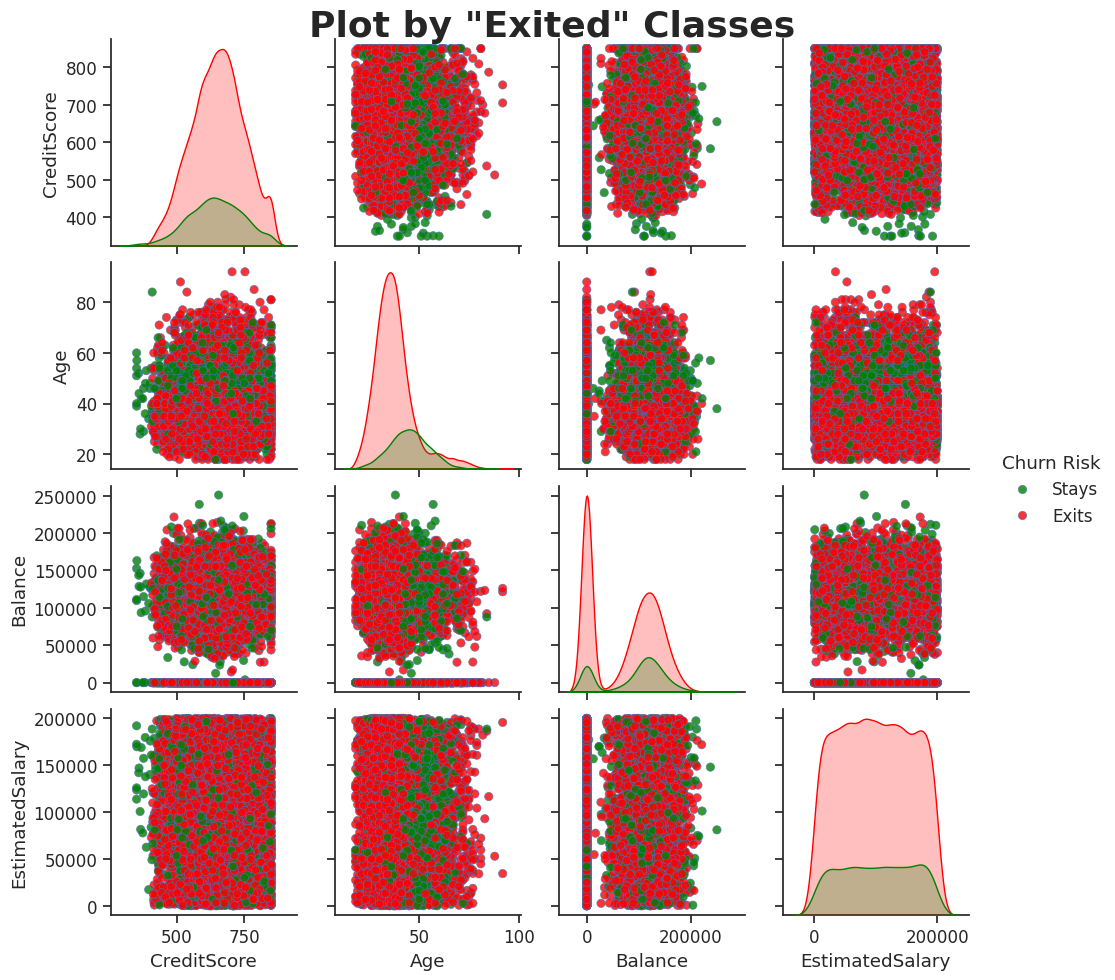

In [ ]:
# Choose meaningful numerical features to avoid clutter
plot_df = df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']].copy()

# Seaborn expects hue column to have class labels for cleaner legend
plot_df['Exited'] = plot_df['Exited'].map({0: 0, 1: 1})  # keep numeric for plot
plot_df['Exited_label'] = plot_df['Exited'].map({0: 'Stays', 1: 'Exits'})

g = sns.pairplot(plot_df.drop('Exited', axis=1),  # drop numeric, use label instead
                 hue='Exited_label',
                 palette={ 'Exits' : 'green', 'Stays' : 'red' },
                 plot_kws={ 'alpha' : 0.8, 'edgecolor' : 'b', 'linewidth' : 0.5 })

# Adjust spacing and title
fig = g.fig
fig.subplots_adjust(top=0.95, wspace=0.2)
fig.suptitle('Plot by "Exited" Classes',
             fontsize=26,
             fontweight='bold')

# Update the legend
new_title = 'Churn Risk'
g._legend.set_title(new_title)

# Replace legend labels
new_labels = ['Stays', 'Exits']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

plt.show()


# confusion matrix

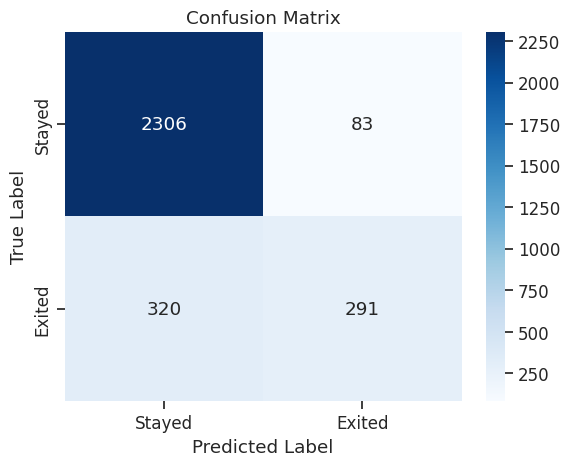

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed', 'Exited'], yticklabels=['Stayed', 'Exited'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# CONCLUSION
The Churn Modelling dataset was used to build a binary classification model to predict whether a bank customer would exit. After cleaning and encoding the data

**XGBoost classifier**

I trained XGB BOOST which obtain the accuracy of approximately 86%

the model performed well overall, especially in identifying customers likely to stay

Visual analysis using a customized pairplot revealed that features like age and account balance had strong associations with churn. This model can help the bank identify at-risk customers and take proactive measures to improve retention